In [82]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [83]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

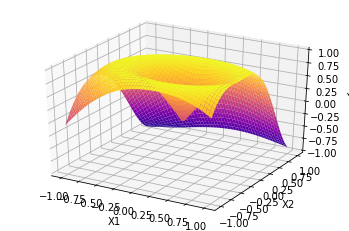

In [84]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [85]:
optimizer = tnn.Adam(0.01)
dynet = tdnn.DynamicNN_Relu([2,2,1], optimizer)

In [86]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

try:
    for epoch in range(100000):
        yout = dynet.forward(xx)
        dy = yout - yy
        dx = dynet.backward(dy)

        dynet.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.46587654378360766
100 Error =  0.023638574251929362
200 Error =  0.01868902323199508
300 Error =  0.01839753636983692
400 Error =  0.018297744859719273
500 Error =  0.018259764554530284
Closing Tk Plot 


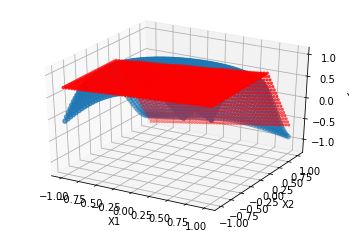

In [87]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

In [88]:
Relu_1Linear = tdnn.Relu_1Linear

In [89]:
dynet_backup = copy.deepcopy(dynet)

In [90]:
def add_neurons_to_all_possible_layers(self, increase_by=1):
    l_ = []
    r0_ = []
    r1_ = []

    new_layers_dim = self.layers_dim.copy()
    new_residuals_dim = self.residuals_dim.copy()
    for i in range(1, len(self.layers_dim)-1 ):
        new_layers_dim[i] += increase_by
        new_residuals_dim[i] += increase_by
    new_residuals_dim[0] += increase_by    

    for i in range(len(self.layers)):
        layer = tnn.LinearLayer(new_layers_dim[i],
                                new_layers_dim[i+1],
                                optimizer=self.optimizer)
        res0 = tnn.NonLinearLayer(new_layers_dim[i],
                                  new_residuals_dim[i],
                                  activation=Relu_1Linear(),
                                  optimizer=self.optimizer)
        res1 = tnn.LinearLayer(new_residuals_dim[i],
                               new_layers_dim[i+1],
                               optimizer=self.optimizer)
        ### copying and zeroing weights
        layer.weights[:self.layers_dim[i], :self.layers_dim[i+1]] = self.layers[i].weights
        layer.bias[:self.layers_dim[i+1]] = self.layers[i].bias
        # the outgoing weights will be zero if the incoming dimension has changed
        layer.weights[self.layers_dim[i]:new_layers_dim[i]] *= 0.
        # similar for residual layer
        res0.weights[:self.layers_dim[i], :self.residuals_dim[i]] = self.residuals_0[i].weights
        res0.bias[:self.residuals_dim[i]] = self.residuals_0[i].bias
        res0.weights[self.layers_dim[i]:new_layers_dim[i]] *= 0.
        # for another residual layer
        res1.weights[:self.residuals_dim[i], :self.layers_dim[i+1]] = self.residuals_1[i].weights
        res1.bias[:self.layers_dim[i+1]] = self.residuals_1[i].bias
        res1.weights[self.residuals_dim[i]:new_residuals_dim[i]] *= 0.
        
#         print(self.residuals_1[i].weights)
#         print(res1.weights)
#         print(res1.weights[self.residuals_dim[i]:new_residuals_dim[i]])
        
        l_.append(layer)
        r0_.append(res0)
        r1_.append(res1)

    self.layers.clear()
    self.residuals_0.clear()
    self.residuals_1.clear()
    self.residuals_dim.clear()
    self.layers_dim.clear()

    self.layers = l_
    self.residuals_0 = r0_
    self.residuals_1 = r1_
    self.residuals_dim = new_residuals_dim
    self.layers_dim = new_layers_dim
    return

In [167]:
add_neurons_to_all_possible_layers(dynet)

Previous Error 0.0073507477903377435
Error 0.007351359049591943


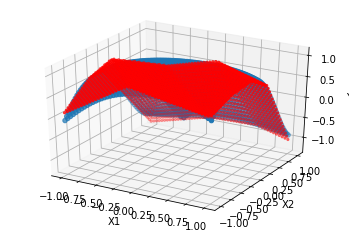

In [168]:
print("Previous Error", error)
yout = dynet.forward(xx)
error = tnn.MseLoss().loss(yout, yy)
print("Error", error)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

In [169]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
try:
    for epoch in range(100000):
        yout = dynet.forward(xx)
        dy = yout - yy
        dx = dynet.backward(dy)

        dynet.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.007351359049591943
100 Error =  0.0037817094522123256
200 Error =  0.0013623562581301307
300 Error =  0.001115529046880659
400 Error =  0.0008945287670664825
500 Error =  0.0008711885474381283
600 Error =  0.0007826482310507094
700 Error =  0.0007486048704213933
800 Error =  0.0007179042670591821
900 Error =  0.0007259762392130775
1000 Error =  0.000663346490301529
1100 Error =  0.0006602974733680135
1200 Error =  0.0006392632783452517
1300 Error =  0.0006264686001140197
1400 Error =  0.0006163204320862853
1500 Error =  0.0006041402403128297
1600 Error =  0.0005917698728847947
1700 Error =  0.0005955986674754217
1800 Error =  0.0005705336745394368
Closing Tk Plot 


In [223]:
# dynet_backup = copy.deepcopy(dynet)
dynet = copy.deepcopy(dynet_backup)

In [224]:
def identify_removable_shortcut_connections(self):
    self.removable_layers = []
    self.trainable_layers = []
    for i in range(len(self.layers)):
#         print(self.layers[i].weights.shape)
#         print(self.residuals_0[i].weights.shape[1])
        h = self.residuals_0[i].weights.shape[1]
        io = self.layers[i].weights.shape
        if h > np.min(io):
#             print(i)
            self.removable_layers.append(i)
        else:
            self.trainable_layers.append(i)
    print(self.removable_layers)
    pass

def set_decay_rate(self, decay_steps=500):
    self.decay_steps = decay_steps
    self.weight_decay_rates = []
#     self.bias_decay_rates = []
    for rl in self.removable_layers:
        w_dr = self.layers[rl].weights/decay_steps
#         b_dr = self.layers[rl].bias/steps
        self.weight_decay_rates.append(w_dr)
#         self.bias_decay_rates.append(b_dr)
    pass    
    
        
def decay_removable_weights(self):
    if self.decay_steps > 0:
        for i, rl in enumerate(self.removable_layers):
            self.layers[rl].weights -= self.weight_decay_rates[i]
        self.decay_steps -= 1
    pass


In [229]:
identify_removable_shortcut_connections(dynet)
set_decay_rate(dynet, 1000)

[0, 2]


In [230]:
dynet.weight_decay_rates

[array([[ 1.46989994e-03, -1.32083859e-03, -9.95160248e-04,
         -6.20838226e-04],
        [-2.13800393e-04,  1.37067279e-03, -1.91434105e-05,
         -2.01813785e-04]]), array([[-0.00045978],
        [-0.00096174],
        [-0.        ]])]

In [231]:
dynet.layers_dim

[2, 4, 3, 1]

In [232]:
dynet.residuals_dim

[3, 2, 2]

In [233]:
for i, rl in enumerate(dynet.removable_layers):
    a = dynet.layers[rl].weights - dynet.decay_steps*dynet.weight_decay_rates[i]
    print(a)

[[ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[0.]
 [0.]
 [0.]]


In [234]:
dynet.trainable_layers

[1]

In [235]:
print(error)

0.0006208636213536306


In [236]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
try:
    for epoch in range(100000):
        decay_removable_weights(dynet)
        yout = dynet.forward(xx)
        dy = yout - yy
        dx = dynet.backward(dy)

        dynet.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.0005701484619482539
100 Error =  0.0005906905669080917
200 Error =  0.000613539917363385
300 Error =  0.0006331530909211935
400 Error =  0.0006508478594465134
500 Error =  0.0006794940092165191
600 Error =  0.0007212991072875974
700 Error =  0.0007478938424413824
800 Error =  0.0007091198769813021
900 Error =  0.0006862082058019017
1000 Error =  0.0007417841539131206
1100 Error =  0.0006980659747805745
1200 Error =  0.0007974716094156535
1300 Error =  0.0006036800381751323
1400 Error =  0.0005802345496437882
1500 Error =  0.0005792452434942182
1600 Error =  0.0005513161920828807
1700 Error =  0.0005411121771953833
1800 Error =  0.0005825839136000245
1900 Error =  0.0005315410965345343
Closing Tk Plot 


In [237]:
dynet.removable_layers

[0, 2]

In [238]:
dynet.layers[0].weights, dynet.layers[0].bias

(array([[-1.85862610e-14, -8.53614054e-15, -3.44169138e-15,
         -6.57113253e-15],
        [-4.79531779e-15,  2.18124130e-14, -2.36139233e-16,
         -1.76502693e-15]]),
 array([-0.5965534 , -0.29732208,  0.44436715,  0.26228448]))

In [239]:
dynet_backup = copy.deepcopy(dynet)

In [247]:
def remove_decayed_layer(self:tdnn.DynamicNN_Relu):
    ### Removable layers are decayed to zero in this case
    self.removable_layers.sort()    
    for i, rl in enumerate(self.removable_layers):
        ### this is to correct the removable layer position that changes due to previous removal of decayed layer 
        ## previously, one is removed and two are added (-1+2=1).
        rl = rl+i
        ### add the bias of the removable layer to the residual out layer
        self.residuals_1[rl].bias += self.layers[rl].bias
        self.layers[rl].bias *= 0.
        
        ### Change the network structure
        ## Make the residuals layer, normal layers
        ## add residual layer to the newly added layers

        del self.layers[rl]
#         del self.layers_dim[rl]
        l0 = tnn.LinearLayer(0, 0,
                            weights=self.residuals_0[rl].weights,
                            bias=self.residuals_0[rl].bias,
                            optimizer=self.optimizer)
        relu = Relu_1Linear()
        l1 = tnn.LinearLayer(0, 0,
                            weights=self.residuals_1[rl].weights,
                            bias=self.residuals_1[rl].bias,
                            optimizer=self.optimizer)
        res0_l0 = tnn.NonLinearLayer(l0.weights.shape[0],
                                  1,
                                  activation=Relu_1Linear(),
                                  optimizer=self.optimizer)
        res1_l0 = tnn.LinearLayer(1,
                               l0.weights.shape[1],
                               optimizer=self.optimizer)
        res1_l0.weights *= 0.
        res0_l1 = tnn.NonLinearLayer(l1.weights.shape[0],
                                  1,
                                  activation=Relu_1Linear(),
                                  optimizer=self.optimizer)
        res1_l1 = tnn.LinearLayer(1,
                               l1.weights.shape[1],
                               optimizer=self.optimizer)
        res1_l1.weights *= 0.
        
        
        
        self.layers.insert(rl, l0)
        self.layers.insert(rl+1, l1)
        self.relus.insert(rl, relu)
        self.layers_dim.insert(rl+1, l0.weights.shape[1])
#         self.layers_dim.insert(rl+1, l1.weights.shape[1])
        
        del self.residuals_0[rl]
        del self.residuals_1[rl]
        self.residuals_0.insert(rl ,res0_l0)
        self.residuals_0.insert(rl+1 ,res0_l1)
        self.residuals_1.insert(rl ,res1_l0)
        self.residuals_1.insert(rl+1 ,res1_l1)
        
        del self.residuals_dim[rl]
        self.residuals_dim.insert(rl, 1)
        self.residuals_dim.insert(rl+1, 1)

In [248]:
remove_decayed_layer(dynet)

In [249]:
dynet.layers

In [250]:
dynet.layers_dim

[2, 3, 4, 3, 2, 1]

In [251]:
dynet.residuals_dim

[1, 1, 2, 1, 1]

In [252]:
dynet.residuals_0

In [253]:
dynet.residuals_1

In [254]:
### below, for reference

In [255]:
dynet.layers

In [256]:
dynet.layers_dim

[2, 3, 4, 3, 2, 1]

In [257]:
dynet.residuals_dim

[1, 1, 2, 1, 1]

In [244]:
dynet.residuals_0

In [245]:
dynet.residuals_1

In [258]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
try:
    for epoch in range(100000):
        yout = dynet.forward(xx)
        dy = yout - yy
        dx = dynet.backward(dy)

        dynet.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.0005301270673467338
100 Error =  0.0005312332834022942
200 Error =  0.0005278308272966605
300 Error =  0.0005269394072919595
400 Error =  0.0005263364466369821
500 Error =  0.0005256049295667527
Closing Tk Plot 


In [222]:
dynet = copy.deepcopy(dynet_backup)